## Ensemble Model: Stacking

In [27]:
# Import necessary libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Flatten, SimpleRNN
from keras.wrappers.scikit_learn import KerasRegressor
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA

### Import Data

In [29]:
df = pickle.load(open('../common/df.p', 'rb'))
feature_cols = pickle.load(open('../common/feature_cols.p', 'rb'))
target_col = ['cpu_usage']

df_reset = df.reset_index()
X = df_reset[feature_cols]
y = df_reset[target_col]

# Split data
train_size = int(len(df) * 0.8)
train, test = df_reset[0:train_size], df_reset[train_size:len(df)]
X_train, y_train = train[feature_cols], train[target_col]
X_test, y_test = test[feature_cols], test[target_col]

### Data Transformation

### Linear Stack

In [30]:
def LinearStack(X_train, y_train, X_val):
    # Models
    var_model = VAR(endog=X_train)
    elasticnet_model = ElasticNet()
    lr_model = LinearRegression()

    # Training models
    # You may need to reshape or further process data to fit the models
    var_result = var_model.fit()
    elasticnet_model.fit(X_train, y_train)
    lr_model.fit(X_train, y_train)

    # Getting predictions
    # var_pred = var_result.forecast(y=X_train.values[-var_result.k_ar:], steps=len(X_val))
    elasticnet_pred = elasticnet_model.predict(X_val)
    lr_pred = lr_model.predict(X_val)

    # Return concatenated predictions
    # return np.c_[var_pred, elasticnet_pred, lr_pred]
    pass

In [31]:
## Linear stack metamodel
def LinearMeta(X_train, y_train, X_val):
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    ridge_pred = ridge.predict(X_val)
    return ridge_pred

### Tree Stack

In [32]:
def TreeStack(X_train, y_train, X_val):
    # Models
    lgbm_model = LGBMRegressor()
    xgb_model = XGBRegressor()
    gbm_model = GradientBoostingRegressor()

    # Train models
    lgbm_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)
    gbm_model.fit(X_train, y_train)

    # Getting predictions
    lgbm_pred = lgbm_model.predict(X_val)
    xgb_pred = xgb_model.predict(X_val)
    gbm_pred = gbm_model.predict(X_val)

    # Return concatenated predictions
    return np.c_[lgbm_pred, xgb_pred, gbm_pred]

In [33]:
## Tree Stack Metamodel
def TreeMeta(X_train, y_train, X_val):
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_val)
    return rf_pred

### Neural Network Stack

In [34]:
def NeuralStack(X_train, y_train, X_val):
    # Your data may need to be reshaped or further preprocessed to fit these models
    # LSTM
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse')
    
    # CNN
    model_cnn = Sequential()
    model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(50, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(optimizer='adam', loss='mse')

    # RNN
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model_rnn.add(Dense(1))
    model_rnn.compile(optimizer='adam', loss='mse')
    
    # Fit models
    model_lstm.fit(X_train, y_train, epochs=200, verbose=0)
    model_cnn.fit(X_train, y_train, epochs=200, verbose=0)
    model_rnn.fit(X_train, y_train, epochs=200, verbose=0)
    
    # Predictions
    lstm_pred = model_lstm.predict(X_val)
    cnn_pred = model_cnn.predict(X_val)
    rnn_pred = model_rnn.predict(X_val)

    return np.c_[lstm_pred, cnn_pred, rnn_pred]

In [35]:
## Neural Stack Metamodel
def NeuralMeta(X_train, y_train, X_val):
    model = Sequential()
    model.add(Dense(10, input_dim=X_train.shape[1], kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='he_normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=300, verbose=0)
    pred = model.predict(X_val)
    return pred

### Stacking Function

In [36]:
def Stacking(X_train, y_train, X_val):
    # Getting base models' predictions
    linear_base_pred = LinearStack(X_train, y_train, X_val)
    tree_base_pred = TreeStack(X_train, y_train, X_val)
    neural_base_pred = NeuralStack(X_train, y_train, X_val)

    # Getting meta models' predictions
    linear_meta_pred = LinearMeta(linear_base_pred, y_train, linear_base_pred)
    tree_meta_pred = TreeMeta(tree_base_pred, y_train, tree_base_pred)
    neural_meta_pred = NeuralMeta(neural_base_pred, y_train, neural_base_pred)

    # Combining meta predictions
    final_prediction = np.mean([linear_meta_pred, tree_meta_pred, neural_meta_pred], axis=0)

    return final_prediction

### Plot Function

In [47]:
def plot_predictions(predictions, model_names, actual):
    actual = actual.reset_index(drop=True)
    colors = ['red', 'green', 'orange', 'purple', 'blue'] # add more colors if you have more than 5 models

    for i in range(predictions.shape[1]):
        plt.figure(figsize=(10,6))
        plt.plot(actual, color='black', label='Actual')
        plt.plot(predictions[:, i], color=colors[i % len(colors)], linestyle='dashed', label=model_names[i])
        plt.title(f'Actual vs Predicted values from {model_names[i]}')
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 6
[LightGBM] [Info] Start training from score 0.168778


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


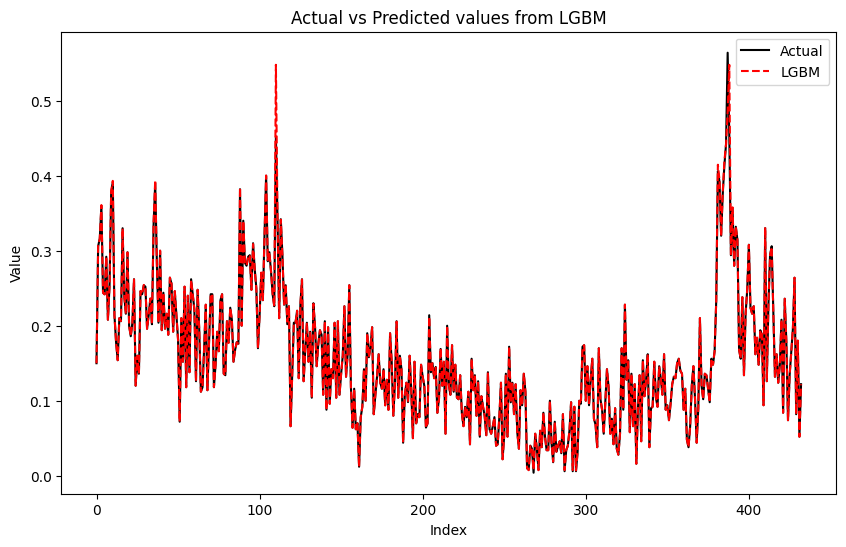

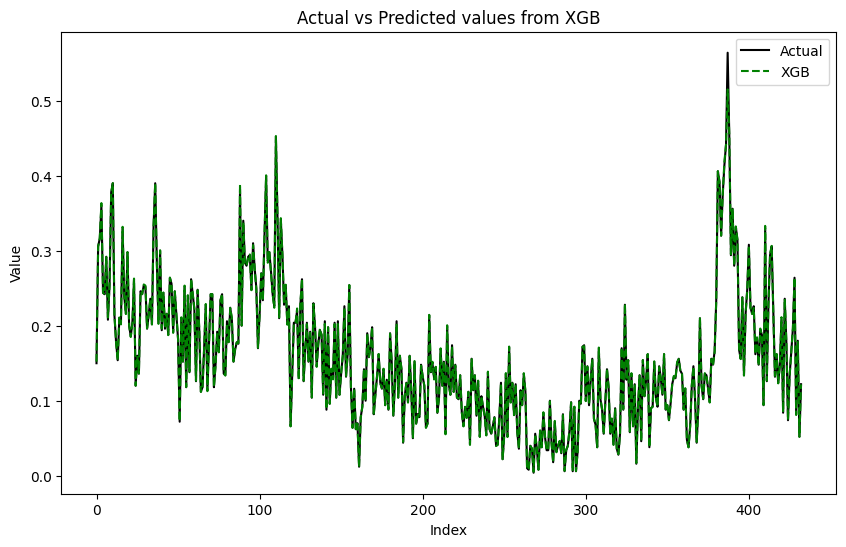

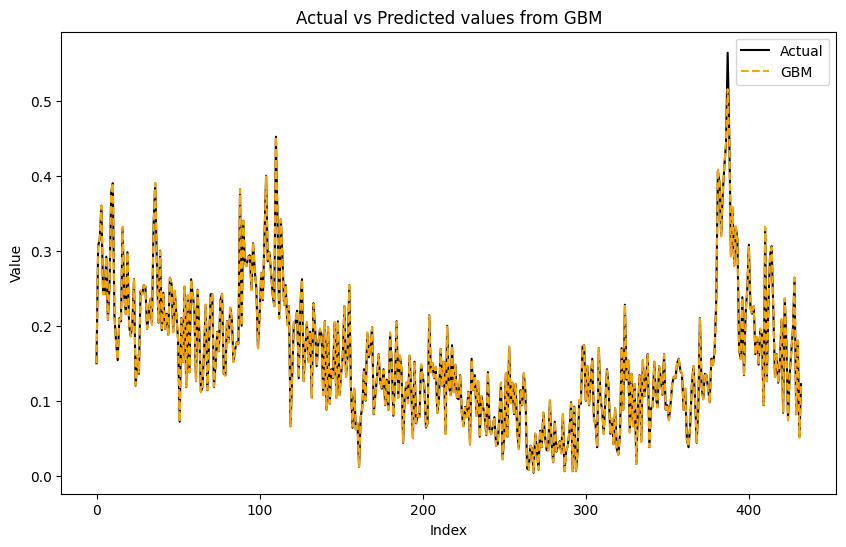

In [48]:
model_names = ['LGBM', 'XGB', 'GBM']
tree_base_pred = TreeStack(X_train, y_train, X_test)

plot_predictions(tree_base_pred, model_names, y_test)